In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from models.imavae import IMAVAE

import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# To make this notebook's output stable across runs
np.random.seed(2020)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. Generate Data without observed covariates

We construct the synthetic data for mediation analysis as below:
\begin{align*}
t &\sim \text{Bernoulli}(p) \\
\boldsymbol{z}_m &\sim \mathcal{N}(0, \sigma_m^2 \textbf{I}) + c_1 \mathbb{1}(t = 1) \\
\boldsymbol{x} &= f(\boldsymbol{z}_m) + c_2 \epsilon_{x} \\
y &= \alpha t + \boldsymbol{\beta}^{\text{T}} \boldsymbol{z}_m + \epsilon_{y}
\end{align*}
where $0 < p < 1$ and $c \in \mathbb{R}$ are constants, $f$ is a nonlinear function which is modeled by an **un-trained** multi-layer perceptron (MLP), $\alpha$ and $\beta$ are the coefficients which build a linear relationship between $\boldsymbol{z}$ and $t, \boldsymbol{y}$, and $\epsilon_{x}$ and $\epsilon_{y}$ are Gaussian noise terms.

In [2]:
N = 6000
p, c1, c2, sigma_m, noise_scale = 0.5, 4, 0.1, 1, 0.1
x_dim, z_m_dim, hidden_dim = 50, 2, 25
f = nn.Sequential(
    nn.Linear(z_m_dim, hidden_dim), 
    nn.LeakyReLU(), 
    nn.Linear(hidden_dim, x_dim)
)

T = np.random.binomial(n=1, p=[p for _ in range(N)]).reshape(-1,1)
Z_m0 = np.random.multivariate_normal(mean=np.zeros(z_m_dim), cov=sigma_m*np.eye(z_m_dim), size=N)
Z_m1 = Z_m0 + c1
Z_m = np.array([Z_m0[i,:] if T[i][0] == 0 else Z_m1[i,:] for i in range(N)])
with torch.no_grad():
    X = f(torch.tensor(Z_m).float()).numpy()
    X += c2 * np.random.randn(X.shape[0],X.shape[1])
alpha = np.random.uniform(-2,2,size=1)
beta = np.random.uniform(-1,1,size=z_m_dim)
noise = noise_scale * np.random.normal(size=N)
Y = (alpha * T.reshape(-1) + Z_m @ beta + noise).reshape(-1,1)

The average causal mediation, direct, and total effect are defined as:
\begin{align}
\bar{\delta}(t) &= \mathbb{E}\left[ Y_i(t, M_i(1)) - Y_i(t, M_i(0)) \right] \\
\bar{\zeta}(t) &= \mathbb{E}\left[ Y_i(1, M_i(t)) - Y_i(0, M_i(t)) \right] \\
\bar{\tau} &= \mathbb{E}\left[ Y_i(1, M_i(1)) - Y_i(0, M_i(0)) \right]
\end{align}

In [3]:
Y0_M0 = (alpha * np.zeros(N) + Z_m0 @ beta + noise).reshape(-1,1)
Y0_M1 = (alpha * np.zeros(N) + Z_m1 @ beta + noise).reshape(-1,1)
Y1_M0 = (alpha * np.ones(N) + Z_m0 @ beta + noise).reshape(-1,1)
Y1_M1 = (alpha * np.ones(N) + Z_m1 @ beta + noise).reshape(-1,1)
acme_c = (Y0_M1 - Y0_M0).mean()
acme_t = (Y1_M1 - Y1_M0).mean()
ade_c = (Y1_M0 - Y0_M0).mean()
ade_t = (Y1_M1 - Y0_M1).mean()
ate = (Y1_M1 - Y0_M0).mean()
print("True ACME (control) = {:.4f}".format(acme_c))
print("True ACME (treatment) = {:.4f}".format(acme_t))
print("True ADE (control) = {:.4f}".format(ade_c))
print("True ADE (treatment) = {:.4f}".format(ade_t))
print("True ATE = {:.4f}".format(ate))

True ACME (control) = 3.1523
True ACME (treatment) = 3.1523
True ADE (control) = -1.0012
True ADE (treatment) = -1.0012
True ATE = 2.1511


# 2. Fit IMAVAE model and evaluate mediation effect

In [4]:
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, 
               optim_name='Adam', recon_weight=0.1, elbo_weight=0.1, sup_weight=1.)
_ = imavae.fit(
    X, T, Y, X_val=X, aux_val=T, y_val=Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(T, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(T, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(T, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(T, treatment=True)
ate_mean, ate_std = imavae.ate_score(T)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

Beginning Training


Epoch: 199, Best Epoch: 178, Best Recon MSE: 0.0101862, Best Pred Metric [0.0173


Saving the last epoch with training MSE: 0.010154 and Pred Metric: [0.017989745, 0.017989745]
Loaded the best model from Epoch: 178 with MSE: 0.0101862 and Pred Metric: [0.01730767, 0.01730767]
ACME (control) = 3.0966 +/- 0.0073
ACME (treatment) = 3.0972 +/- 0.0070
ADE (control) = -0.9432 +/- 0.0000
ADE (treatment) = -0.9432 +/- 0.0000
ATE = 2.1544 +/- 0.0068
-------------------------------------
ACME err (control) = 0.0556 +/- 0.0073
ACME err (treatment) = 0.0551 +/- 0.0070
ADE err (control) = 0.0580 +/- 0.0000
ADE err (treatment) = 0.0580 +/- 0.0000
ATE err = 0.0033 +/- 0.0068


### 2.1 Does the latent feature learned by IMAVAE recover the true mediator?

/var/folders/f7/ng9rrn3j6nq2wy53cjpq4bmr0000gp/T/ipykernel_3582/2492788245.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  axs[1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)


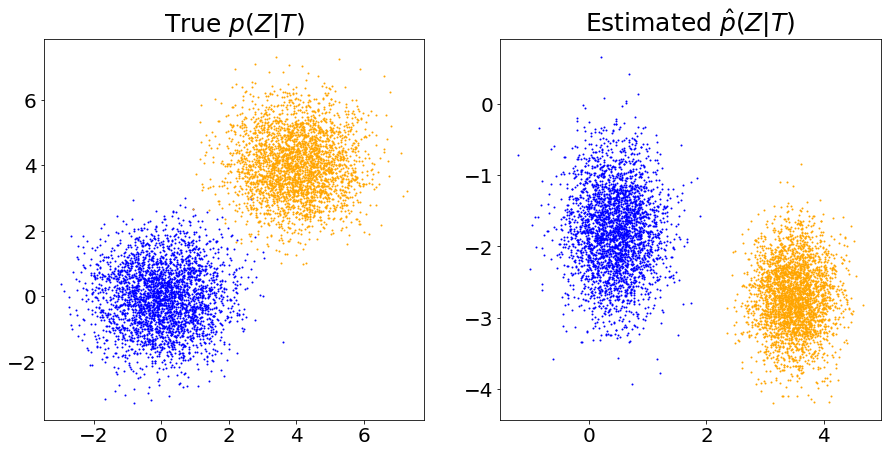

In [5]:
with torch.no_grad():
    t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
    z_m0 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
    z_m1 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
    # Estimated z_m for factual outcomes
    z_m = torch.stack([z_m0[i,:] if T[i,0] == 0 else z_m1[i,:] for i in range(N)])

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,7))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(Z_m[i,0], Z_m[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_title("True $p(Z|T)$", size=25)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_title("Estimated $\hat{p}(Z|T)$", size=25)
plt.savefig('./Figures/case_a_lr.png', dpi=1200)

#### 2.1.1 How does the reconstructed $X$ look like?

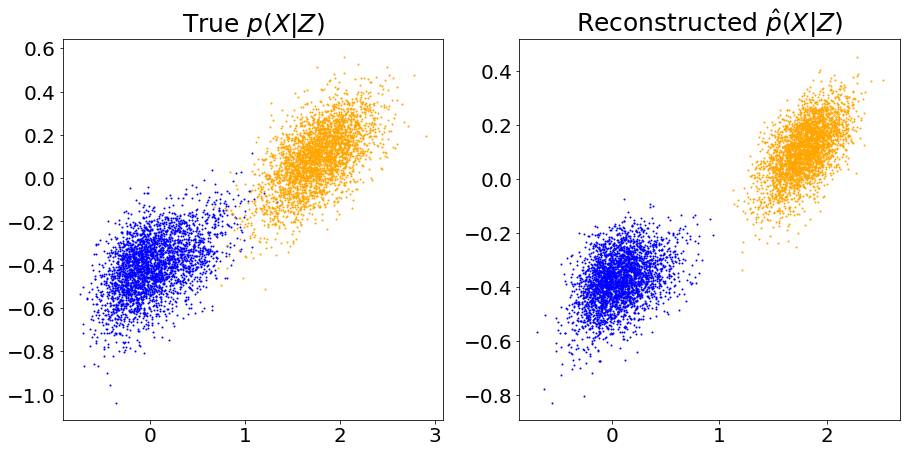

In [6]:
# Only plot the first 2 dimensions of X for better visualization
with torch.no_grad():
    x_m = imavae.ivae.decoder_dist.sample(*imavae.ivae.decoder_params(z_m))

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,7))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(X[i,0], X[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(x_m[i,0], x_m[i,1], c=c_dict[g], label=g, s=1)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_title("True $p(X|Z)$", size=25)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_title("Reconstructed $\hat{p}(X|Z)$", size=25)
plt.savefig('./Figures/case_a_recon.png', dpi=1200)

### 2.2 What if we use a multi-layer perceptron for $g_{\boldsymbol{\gamma}}$ ?

In [7]:
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, n_sup_hidden_layers=1,
                n_sup_hidden_dim=20, optim_name='Adam', recon_weight=0.1, elbo_weight=0.1, sup_weight=1.)
_ = imavae.fit(
    X, T, Y, X_val=X, aux_val=T, y_val=Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(T, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(T, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(T, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(T, treatment=True)
ate_mean, ate_std = imavae.ate_score(T)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

Beginning Training


Epoch: 199, Best Epoch: 177, Best Recon MSE: 0.0102212, Best Pred Metric [0.0147


Saving the last epoch with training MSE: 0.0101957 and Pred Metric: [0.0154738845, 0.0154738845]
Loaded the best model from Epoch: 177 with MSE: 0.0102212 and Pred Metric: [0.014710584, 0.014710584]
ACME (control) = 3.1789 +/- 0.0076
ACME (treatment) = 3.4883 +/- 0.0078
ADE (control) = -1.2804 +/- 0.0017
ADE (treatment) = -0.9719 +/- 0.0000
ATE = 2.2071 +/- 0.0069
-------------------------------------
ACME err (control) = 0.0266 +/- 0.0076
ACME err (treatment) = 0.3361 +/- 0.0078
ADE err (control) = 0.2792 +/- 0.0017
ADE err (treatment) = 0.0294 +/- 0.0000
ATE err = 0.0560 +/- 0.0069


Text(0.5, 1.0, 'Estimated $\\hat{p}(Z|T)$')

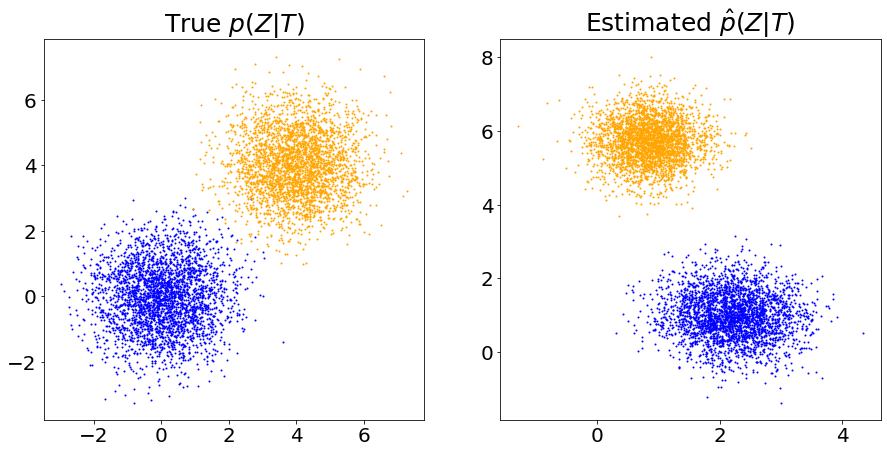

In [8]:
with torch.no_grad():
    t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
    z_m0 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
    z_m1 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
    # Estimated z_m for factual outcomes
    z_m = torch.stack([z_m0[i,:] if T[i,0] == 0 else z_m1[i,:] for i in range(N)])

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,7))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(Z_m[i,0], Z_m[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_title("True $p(Z|T)$", size=25)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_title("Estimated $\hat{p}(Z|T)$", size=25)

#### 2.2.1 What if we increase the number of parameters of the MLP for $g_{\boldsymbol{\gamma}}$?

In [9]:
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, n_sup_hidden_layers=2,
                n_sup_hidden_dim=20, optim_name='Adam', recon_weight=0.1, elbo_weight=0.1, sup_weight=1.)
_ = imavae.fit(
    X, T, Y, X_val=X, aux_val=T, y_val=Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(T, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(T, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(T, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(T, treatment=True)
ate_mean, ate_std = imavae.ate_score(T)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

Beginning Training


Epoch: 199, Best Epoch: 195, Best Recon MSE: 0.010268, Best Pred Metric [0.01628


Saving the last epoch with training MSE: 0.0101953 and Pred Metric: [0.018190837, 0.018190837]
Loaded the best model from Epoch: 195 with MSE: 0.010268 and Pred Metric: [0.016286986, 0.016286986]
ACME (control) = 2.3658 +/- 0.0077
ACME (treatment) = 5.5444 +/- 0.0158
ADE (control) = -3.3980 +/- 0.0116
ADE (treatment) = -0.2210 +/- 0.0045
ATE = 2.1454 +/- 0.0073
-------------------------------------
ACME err (control) = 0.7865 +/- 0.0077
ACME err (treatment) = 2.3921 +/- 0.0158
ADE err (control) = 2.3968 +/- 0.0116
ADE err (treatment) = 0.7802 +/- 0.0045
ATE err = 0.0057 +/- 0.0073


In [10]:
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, n_sup_hidden_layers=3,
                n_sup_hidden_dim=20, optim_name='Adam', recon_weight=0.1, elbo_weight=0.1, sup_weight=1.)
_ = imavae.fit(
    X, T, Y, X_val=X, aux_val=T, y_val=Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(T, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(T, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(T, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(T, treatment=True)
ate_mean, ate_std = imavae.ate_score(T)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

Beginning Training


Epoch: 199, Best Epoch: 194, Best Recon MSE: 0.010078, Best Pred Metric [0.02036


Saving the last epoch with training MSE: 0.010092 and Pred Metric: [0.023080109, 0.023080109]
Loaded the best model from Epoch: 194 with MSE: 0.010078 and Pred Metric: [0.020361857, 0.020361857]
ACME (control) = 1.8636 +/- 0.0115
ACME (treatment) = 0.7715 +/- 0.0427
ADE (control) = 1.4076 +/- 0.0439
ADE (treatment) = 0.3249 +/- 0.0093
ATE = 2.1889 +/- 0.0075
-------------------------------------
ACME err (control) = 1.2887 +/- 0.0115
ACME err (treatment) = 2.3807 +/- 0.0427
ADE err (control) = 2.4089 +/- 0.0439
ADE err (treatment) = 1.3261 +/- 0.0093
ATE err = 0.0378 +/- 0.0075


### 2.3 What if we get rid of the reconstruction term?

In [11]:
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, 
               optim_name='Adam', recon_weight=-1., elbo_weight=0.1, sup_weight=1.)
_ = imavae.fit(
    X, T, Y, X_val=X, aux_val=T, y_val=Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(T, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(T, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(T, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(T, treatment=True)
ate_mean, ate_std = imavae.ate_score(T)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

Beginning Training


Epoch: 199, Best Epoch: 194, Best Recon MSE: 0.0102449, Best Pred Metric [0.0195


Saving the last epoch with training MSE: 0.0102799 and Pred Metric: [0.020109812, 0.020109812]
Loaded the best model from Epoch: 194 with MSE: 0.0102449 and Pred Metric: [0.01953011, 0.01953011]
ACME (control) = 3.0900 +/- 0.0083
ACME (treatment) = 3.0905 +/- 0.0072
ADE (control) = -0.9336 +/- 0.0000
ADE (treatment) = -0.9336 +/- 0.0000
ATE = 2.1559 +/- 0.0072
-------------------------------------
ACME err (control) = 0.0622 +/- 0.0083
ACME err (treatment) = 0.0618 +/- 0.0072
ADE err (control) = 0.0676 +/- 0.0000
ADE err (treatment) = 0.0676 +/- 0.0000
ATE err = 0.0049 +/- 0.0072


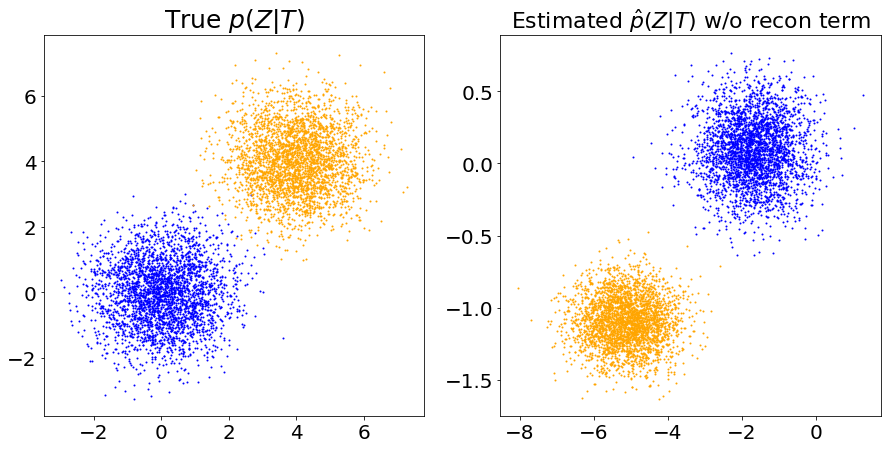

In [12]:
with torch.no_grad():
    t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
    z_m0 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
    z_m1 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
    # Estimated z_m for factual outcomes
    z_m = torch.stack([z_m0[i,:] if T[i,0] == 0 else z_m1[i,:] for i in range(N)])

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,7))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(Z_m[i,0], Z_m[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_title("True $p(Z|T)$", size=25)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_title("Estimated $\hat{p}(Z|T)$ w/o recon term", size=22)
plt.savefig('./Figures/case_a_lr_wo_recon.png', dpi=1200)

### 2.4 What if we get rid of the ELBO term?

In [13]:
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, 
               optim_name='Adam', recon_weight=0.1, elbo_weight=0., sup_weight=1.)
_ = imavae.fit(
    X, T, Y, X_val=X, aux_val=T, y_val=Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(T, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(T, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(T, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(T, treatment=True)
ate_mean, ate_std = imavae.ate_score(T)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

Beginning Training


Epoch: 199, Best Epoch: 198, Best Recon MSE: 0.0120483, Best Pred Metric [0.0129


Saving the last epoch with training MSE: 0.0121144 and Pred Metric: [0.013171427, 0.013171427]
Loaded the best model from Epoch: 198 with MSE: 0.0120483 and Pred Metric: [0.012983973, 0.012983973]
ACME (control) = 0.1378 +/- 0.0244
ACME (treatment) = 0.1329 +/- 0.0215
ADE (control) = 0.5876 +/- 0.0000
ADE (treatment) = 0.5876 +/- 0.0000
ATE = 0.7247 +/- 0.0231
-------------------------------------
ACME err (control) = 3.0145 +/- 0.0244
ACME err (treatment) = 3.0194 +/- 0.0215
ADE err (control) = 1.5888 +/- 0.0000
ADE err (treatment) = 1.5888 +/- 0.0000
ATE err = 1.4264 +/- 0.0231


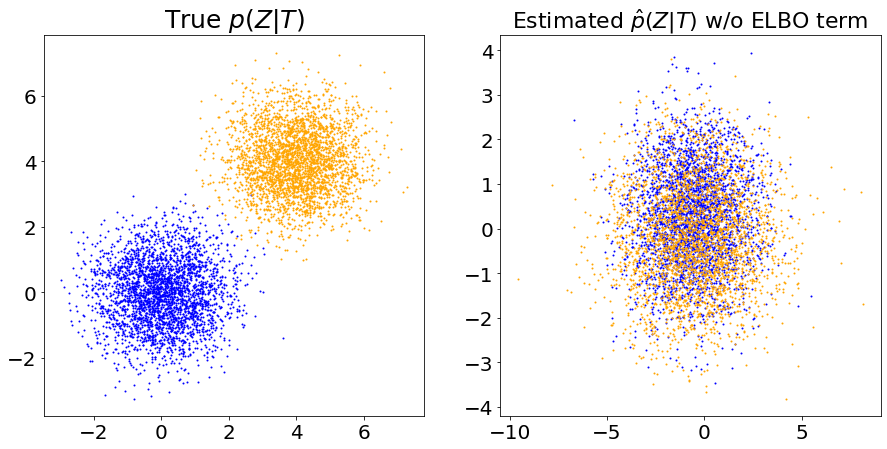

In [14]:
with torch.no_grad():
    t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
    z_m0 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
    z_m1 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
    # Estimated z_m for factual outcomes
    z_m = torch.stack([z_m0[i,:] if T[i,0] == 0 else z_m1[i,:] for i in range(N)])

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,7))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(Z_m[i,0], Z_m[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_title("True $p(Z|T)$", size=25)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_title("Estimated $\hat{p}(Z|T)$ w/o ELBO term", size=22)
plt.savefig('./Figures/case_a_lr_wo_elbo.png', dpi=1200)